# Accelerating Deep Learning with Multiprocess Image Augmentation in Keras

When exploring Deep Learning models, it isn't only beneficial to have good performance for the final training run. Accelerating training speed means more network models can be tried and more hyperparameter settings can be explored in the same amount of time. **The more that we can experiment, the better our results can become.**

In my experience with [training a moderately sized network](http://blog.stratospark.com/deep-learning-applied-food-classification-deep-learning-keras.html) on my home desktop, I found one bottleneck to be creating additional images to augment my dataset. Keras provides an [ImageDataGenerator](https://keras.io/preprocessing/image/) class that can take images, in memory or on disk, and create many different variations based on a set of parameters: rotations, flips, zooms, altering colors, etc. For reference, here is a [great tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) on improving network accuracy with image augmentation.

![cat images augmented](https://blog.keras.io/img/imgclf/cat_data_augmentation.png)

While training my initial models, I was waiting upwards of an entire day to see enough results to decide what to change. I saw that I was taking nowhere near full advantage of my CPU or GPU. As a result, I decided to add some Python multiprocessing support to a fork of ImageDataGenerator. I was able to **cut training time per epoch in half** and was finally able to steer my experiments in the right direction!

You can use the multiprocessing-enabled ImageDataGenerator that is included with this repo as a drop-in replacement for the version that currently ships with Keras. If it makes sense, the code may get incorporated into the main branch at some point.

In [1]:
import numpy as np
import pandas as pd
import keras as K
import matplotlib.pyplot as plt
import multiprocessing
import time
import collections
import sys
import signal

%matplotlib inline

Using TensorFlow backend.


In [2]:
# The original class can be imported like this:
# from keras.preprocessing.image import ImageDataGenerator

# We access the modified version through T.ImageDataGenerator
import tools.image as T

# Useful for checking the output of the generators after code change
try:
    from importlib import reload
    reload(T)
except:
    reload(T)

These are helper methods used throughout the notebook.

In [3]:
def preprocess_img(img):
    img = img.astype(np.float32) / 255.0
    img -= 0.5
    return img * 2

In [4]:
def plot_images(img_gen, title):
    fig, ax = plt.subplots(6, 6, figsize=(10, 10))
    plt.suptitle(title, size=32)
    plt.setp(ax, xticks=[], yticks=[])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    for (imgs, labels) in img_gen:
        for i in range(6):
            for j in range(6):
                if i*6 + j < 32:
                    ax[i][j].imshow(imgs[i*6 + j])
        break    

## CIFAR10 - In Memory Performance, Only Generation

[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) is a toy dataset that includes 50,000 training images and 10,000 test images of shape 32x32x3.

It includes the following 10 classes: **airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck**

In [5]:
from keras.datasets.cifar10 import load_data
from keras.utils.np_utils import to_categorical

(X_train, y_train), (X_test, y_test) = load_data()

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

Here is an example of how to set up a `multiprocessing.Pool` and add it as an argument to the ImageDataGenerator constructor. This is the only change to the class' public interface. If you leave out the `pool` parameter or set it to `None`, the generator will operate in its original single process mode.

4 process, duration: 0.046168088913


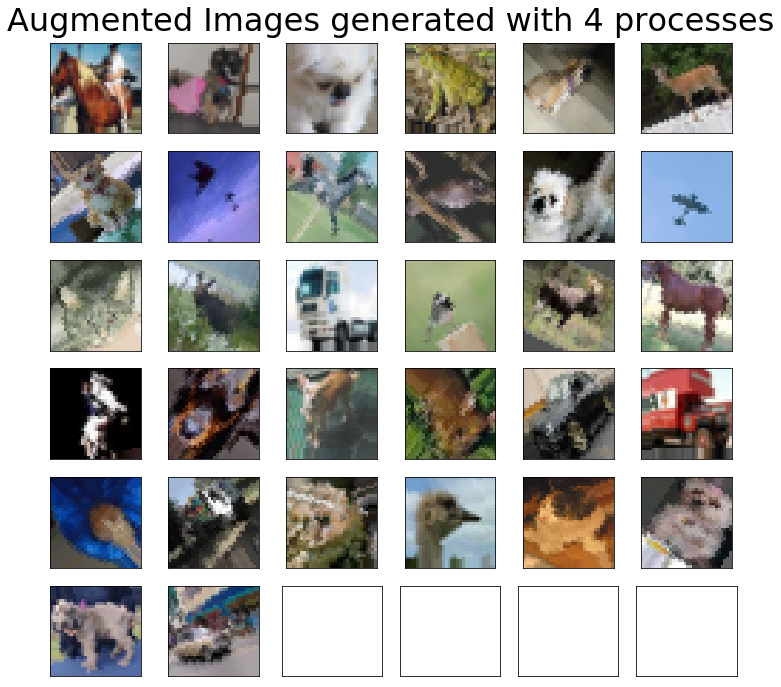

In [6]:
try:
    pool.terminate()
except:
    pass
n_process = 4
    
pool = multiprocessing.Pool(processes=n_process)
start = time.time()
gen = T.ImageDataGenerator(
     featurewise_center=False,
     samplewise_center=False,
     featurewise_std_normalization=False,
     samplewise_std_normalization=False,
     zca_whitening=False,
     rotation_range=45,
     width_shift_range=.1,
     height_shift_range=.1,
     shear_range=0.,
     zoom_range=0,
     channel_shift_range=0,
     fill_mode='nearest',
     cval=0.,
     horizontal_flip=True,
     vertical_flip=False,
     rescale=1/255.,
     #preprocessing_function=preprocess_img, # disable for nicer visualization
     dim_ordering='default',
     pool=pool # <-------------- Only change needed!
)

gen.fit(X_train)
X_train_aug = gen.flow(X_train, y_train_cat, seed=0)

print('{} process, duration: {}'.format(4, time.time() - start))
plot_images(X_train_aug, 'Augmented Images generated with {} processes'.format(n_process))

pool.terminate()

Now that we have verified that the images are being properly generated with multiple processes, we want to benchmark how the number of processes affects performance. Idealy, we would like to see speedups scale linearly with the number of processes added. However, as explained by [Amdahl's Law](https://en.wikipedia.org/wiki/Amdahl%27s_law), there are diminishing returns due to additional overhead.

The following benchmark will first test image augmentation without multiprocessing, then do a test for an increasing number of processes, up to a max of the number of logical CPUs your system has. It does multiple rounds of these tests so that we may average the results.

In [7]:
durs = collections.defaultdict(list)
num_cores = 2
try:
    num_cores = multiprocessing.cpu_count()
except:
    pass

for j in range(10):
    print('Round', j)
    
    for num_p in range(0, num_cores + 1):
        pool = None
        if num_p > 0:
            pool = multiprocessing.Pool(processes=num_p)
            
        start = time.time()
        gen = T.ImageDataGenerator(
             featurewise_center=False,
             samplewise_center=False,
             featurewise_std_normalization=False,
             samplewise_std_normalization=False,
             zca_whitening=False,
             rotation_range=45,
             width_shift_range=.1,
             height_shift_range=.1,
             shear_range=0.,
             zoom_range=0,
             channel_shift_range=0,
             fill_mode='nearest',
             cval=0.,
             horizontal_flip=True,
             vertical_flip=False,
             rescale=None,
             preprocessing_function=preprocess_img,
             dim_ordering='default',
             pool=pool
        )

        gen.fit(X_train)
        X_train_aug = gen.flow(X_train, y_train_cat, seed=0)

        for i, (imgs, labels) in enumerate(X_train_aug):
            if i == 1000:
                break

        dur = time.time() - start
        #print(num_p, dur)
        sys.stdout.write('{}: {} ... '.format(num_p, dur))
        sys.stdout.flush()
        
        durs[num_p].append(dur)

        if pool:
            pool.terminate()

('Round', 0)
0: 6.98968219757 ... 1: 11.2660729885 ... 2: 5.90767598152 ... 3: 5.10887694359 ... 4: 4.37561297417 ... 5: 3.64697909355 ... 6: 3.75319910049 ... 7: 3.27360606194 ... 8: 3.73721504211 ... 9: 3.70412683487 ... 10: 3.4944229126 ... 11: 3.55238580704 ... 12: 3.65764713287 ... ('Round', 1)
0: 6.83337306976 ... 1: 10.0099768639 ... 2: 5.53906607628 ... 3: 5.13761901855 ... 4: 4.40284800529 ... 5: 3.83379507065 ... 6: 3.84568500519 ... 7: 3.14165091515 ... 8: 3.47027897835 ... 9: 3.43323707581 ... 10: 3.59811496735 ... 11: 3.45790505409 ... 12: 3.64167499542 ... ('Round', 2)
0: 6.77511096001 ... 1: 9.96791601181 ... 2: 5.7335960865 ... 3: 4.72253990173 ... 4: 4.41862297058 ... 5: 3.62644314766 ... 6: 3.44153404236 ... 7: 3.35751700401 ... 8: 3.56314206123 ... 9: 3.88625693321 ... 10: 3.77437615395 ... 11: 3.4738111496 ... 12: 3.50257992744 ... ('Round', 3)
0: 6.67881989479 ... 1: 10.0319769382 ... 2: 6.12446188927 ... 3: 4.93781590462 ... 4: 4.16471195221 ... 5: 3.89352202415 .

In [8]:
df = pd.DataFrame(durs)
df

0          1         2         3         4         5         6   \
0  6.989682  11.266073  5.907676  5.108877  4.375613  3.646979  3.753199   
1  6.833373  10.009977  5.539066  5.137619  4.402848  3.833795  3.845685   
2  6.775111   9.967916  5.733596  4.722540  4.418623  3.626443  3.441534   
3  6.678820  10.031977  6.124462  4.937816  4.164712  3.893522  3.777616   
4  6.737393   9.854759  5.589112  4.802850  4.511250  4.048070  3.896447   
5  6.723225   9.836899  6.064634  5.012578  4.613770  4.460686  4.063562   
6  7.195923   9.439181  5.844888  4.978489  4.354995  4.155922  3.843439   
7  6.791469   9.258435  6.552125  5.169746  4.515641  4.093974  4.323477   
8  6.731282   9.856614  6.178925  4.950315  4.714781  4.212883  3.688998   
9  6.750934   9.521506  6.009775  4.998496  4.275394  3.743047  3.682914   

         7         8         9         10        11        12  
0  3.273606  3.737215  3.704127  3.494423  3.552386  3.657647  
1  3.141651  3.470279  3.433237  3.598115  3.457905  3.641675  
2  3.357517  3.563142  3.886257  3.774376  3.473811  3.502580  
3  3.431391  3.624308  3.575341  3.630136  3.558901  3.477697  
4  3.158443  4.036366  3.628940  3.700624  3.623293  3.524937  
5  3.091110  3.306276  3.621002  3.661916  3.528031  3.566477  
6  3.335115  3.637589  3.821717  3.579432  3.498215  3.487188  
7  3.195154  3.585876  3.400990  3.557827  3.475703  3.487595  
8  3.087973  3.881872  3.902012  3.575810  3.562260  3.553968  
9  3.381168  3.503953  3.670602  3.616002  3.562964  3.636442

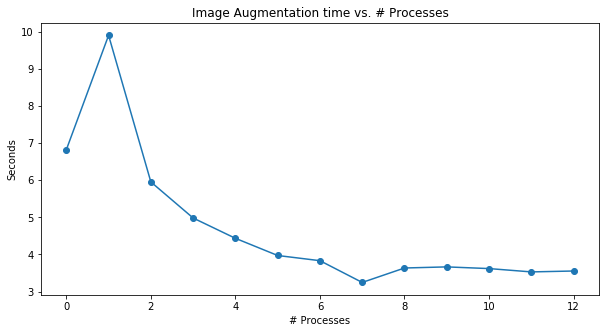

In [9]:
df_mean = pd.DataFrame(df.mean(axis=0))
plt.figure(figsize=(10,5))
plt.plot(df_mean, marker='o')
plt.xlabel('# Processes')
plt.ylabel('Seconds')
plt.title('Image Augmentation time vs. # Processes')

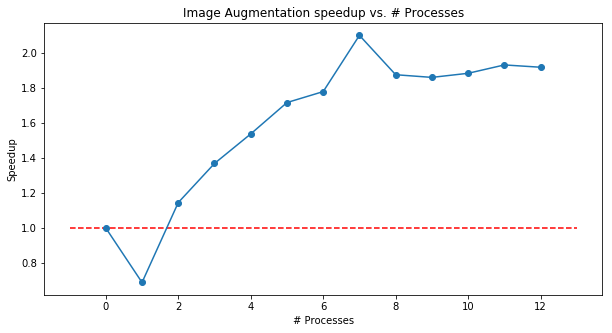

In [10]:
speedups = 1 / (df_mean / df_mean[0][0])
plt.figure(figsize=(10,5))
plt.plot(speedups, marker='o')
plt.xlabel('# Processes')
plt.ylabel('Speedup')
plt.hlines(1, -1, df_mean.shape[0], colors='red', linestyles='dashed')
plt.title('Image Augmentation speedup vs. # Processes')

In [11]:
best_ix = np.argmax(speedups.values)
print('Best speedup: {0:.2f}x with {1} processes.'.format(speedups.values[best_ix][0], best_ix))

Best speedup: 2.10x with 7 processes.


As we can see, we are able to cut image generation time in half. However, does the speedup remain when we are also sending the images to the GPU for network trianing?

## CIFAR10 - In Memory Performance, Generation with GPU Training

In [41]:
import tools.sysmonitor as SM
reload(SM)

<module 'tools.sysmonitor' from 'tools/sysmonitor.py'>

Let us take a model from one of the [Keras examples](https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py):

In [45]:
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, 3, 3, border_mode='same',
                        input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_8 (Convolution2D)  (None, 32, 32, 32)    896         convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
activation_12 (Activation)       (None, 32, 32, 32)    0           convolution2d_8[0][0]            
____________________________________________________________________________________________________
convolution2d_9 (Convolution2D)  (None, 30, 30, 32)    9248        activation_12[0][0]              
____________________________________________________________________________________________________
activation_13 (Activation)       (None, 30, 30, 32)    0           convolution2d_9[0][0]            
___________________________________________________________________________________________

When we are running lengthier training sessions, we may want to interrupt training to try a different approach: tweak hyperparameters, choose a different optimizer, adjust the network architecture, etc. In order to handle this gracefully with multiprocessing, we need to tell the child processes to ignore the interrupt signals. The parent process will catch the KeyboardInterrupt exception allow us to continue working interactively in the Notebook. Without this infrastructure, the processes will remain in limbo as detailed [here](http://noswap.com/blog/python-multiprocessing-keyboardinterrupt).

In [14]:
pool = None

def init_worker():
    signal.signal(signal.SIGINT, signal.SIG_IGN)

In [15]:
def setup_generator(processes=None, batch_size=32):
    global pool
    try:
        pool.terminate()
    except:
        pass

    if processes: 
        pool = multiprocessing.Pool(processes=processes, initializer=init_worker)
    else:
        pool = None

    gen = T.ImageDataGenerator(
         featurewise_center=False,
         samplewise_center=False,
         featurewise_std_normalization=False,
         samplewise_std_normalization=False,
         zca_whitening=False,
         rotation_range=45,
         width_shift_range=.1,
         height_shift_range=.1,
         shear_range=0.,
         zoom_range=[.8, 1],
         channel_shift_range=20,
         fill_mode='nearest',
         cval=0.,
         horizontal_flip=True,
         vertical_flip=False,
         rescale=None,
         preprocessing_function=preprocess_img,
         dim_ordering='default',
         pool=pool
    )
    test_gen = T.ImageDataGenerator(
        preprocessing_function=preprocess_img,
        pool=pool
    )
    
    gen.fit(X_train)
    test_gen.fit(X_train)
    
    X_train_aug = gen.flow(X_train, y_train_cat, seed=0, batch_size=batch_size)
    X_test_aug = test_gen.flow(X_test, y_test_cat, seed=0, batch_size=batch_size)
    
    return X_train_aug, X_test_aug

In [42]:
def run_benchmark(processes=None, batch_size=32, vert=False):
    X_train_aug, X_test_aug = setup_generator(processes=processes, batch_size=batch_size)
    sys_mon = SM.SysMonitor()
    sys_mon.start()
    
    try:
        model.fit_generator(X_train_aug, samples_per_epoch=50000, nb_epoch=5, 
                        validation_data=X_test_aug, nb_val_samples=10000)
    except KeyboardInterrupt:
        print '\n\nTraining Interrupted\n'
        return None

    sys_mon.stop()
    
    title = None
    if not processes:
        title = '{0:.2f} seconds of computation, no multiprocessing, batch size = {1}'.format(sys_mon.duration, batch_size)
    else:
        title = '{0:.2f} seconds of computation, using {1} processes, batch size = {2}'.format(sys_mon.duration, processes, 32)
    
    sys_mon.plot(title, vert)
    
    if not processes:
        processes = 0
        
    return {
        'processes': processes,
        'batch_size': batch_size,
        'duration': sys_mon.duration,
        'title': title
    }

Epoch 1/5
50000/50000 [==============================] - 23s - loss: 1.7645 - acc: 0.3582 - val_loss: 1.2871 - val_acc: 0.5425
Epoch 2/5
50000/50000 [==============================] - 22s - loss: 1.4777 - acc: 0.4689 - val_loss: 1.1996 - val_acc: 0.5688
Epoch 3/5
50000/50000 [==============================] - 22s - loss: 1.3645 - acc: 0.5147 - val_loss: 1.0489 - val_acc: 0.6295
Epoch 4/5
50000/50000 [==============================] - 21s - loss: 1.3012 - acc: 0.5360 - val_loss: 0.9923 - val_acc: 0.6495
Epoch 5/5
50000/50000 [==============================] - 24s - loss: 1.2694 - acc: 0.5509 - val_loss: 0.9858 - val_acc: 0.6591


{'batch_size': 32,
 'duration': 115.42897605895996,
 'processes': 0,
 'title': '115.43 seconds of computation, no multiprocessing, batch size = 32'}

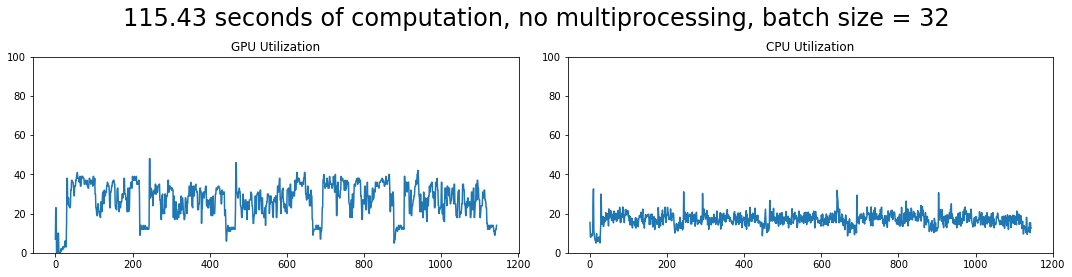

In [17]:
run_benchmark(processes=None, batch_size=32)

Epoch 1/5
50000/50000 [==============================] - 11s - loss: 1.2154 - acc: 0.5671 - val_loss: 0.9510 - val_acc: 0.6646
Epoch 2/5
50000/50000 [==============================] - 11s - loss: 1.1973 - acc: 0.5766 - val_loss: 0.9453 - val_acc: 0.6642
Epoch 3/5
50000/50000 [==============================] - 11s - loss: 1.1804 - acc: 0.5830 - val_loss: 0.8875 - val_acc: 0.6868
Epoch 4/5
50000/50000 [==============================] - 11s - loss: 1.1547 - acc: 0.5906 - val_loss: 0.8753 - val_acc: 0.6922
Epoch 5/5
50000/50000 [==============================] - 11s - loss: 1.1420 - acc: 0.5976 - val_loss: 0.8834 - val_acc: 0.6876


{'batch_size': 32,
 'duration': 56.89765691757202,
 'processes': 7,
 'title': '56.90 seconds of computation, using 7 processes, batch size = 32'}

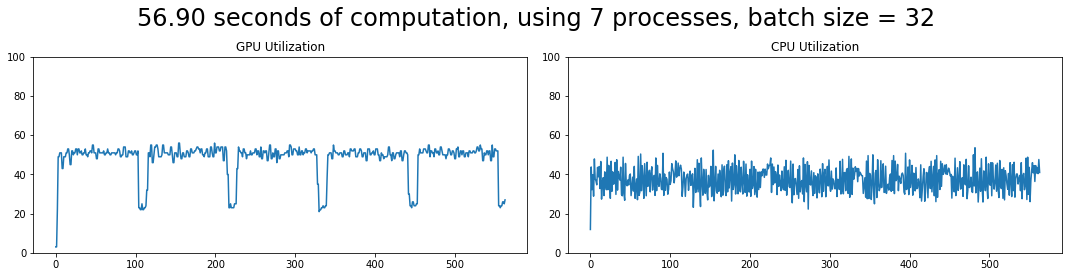

In [18]:
run_benchmark(processes=7, batch_size=32)

Now let's try a variety of different test scenarios:

In [19]:
runs = []

Epoch 1/5
50000/50000 [==============================] - 21s - loss: 1.1603 - acc: 0.5919 - val_loss: 0.8470 - val_acc: 0.7055
Epoch 2/5
50000/50000 [==============================] - 21s - loss: 1.1465 - acc: 0.5987 - val_loss: 0.8763 - val_acc: 0.6939
Epoch 3/5
50000/50000 [==============================] - 22s - loss: 1.1363 - acc: 0.6003 - val_loss: 0.8365 - val_acc: 0.7088
Epoch 4/5
50000/50000 [==============================] - 22s - loss: 1.1240 - acc: 0.6057 - val_loss: 0.8632 - val_acc: 0.7012
Epoch 5/5
50000/50000 [==============================] - 22s - loss: 1.1133 - acc: 0.6093 - val_loss: 0.8221 - val_acc: 0.7124


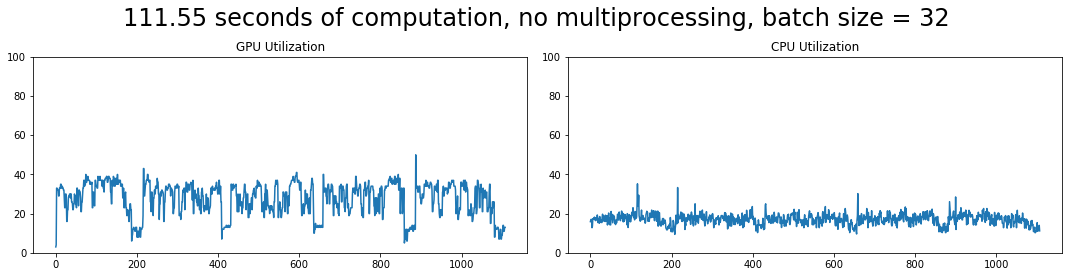

In [20]:
runs.append(run_benchmark(processes=None, batch_size=32))

Epoch 1/5
50000/50000 [==============================] - 11s - loss: 1.0953 - acc: 0.6134 - val_loss: 0.8267 - val_acc: 0.7045
Epoch 2/5
50000/50000 [==============================] - 11s - loss: 1.0830 - acc: 0.6218 - val_loss: 0.8926 - val_acc: 0.6889
Epoch 3/5
50000/50000 [==============================] - 11s - loss: 1.0745 - acc: 0.6237 - val_loss: 0.8002 - val_acc: 0.7253
Epoch 4/5
50000/50000 [==============================] - 11s - loss: 1.0626 - acc: 0.6266 - val_loss: 0.8065 - val_acc: 0.7225
Epoch 5/5
50000/50000 [==============================] - 11s - loss: 1.0693 - acc: 0.6268 - val_loss: 0.7976 - val_acc: 0.7226


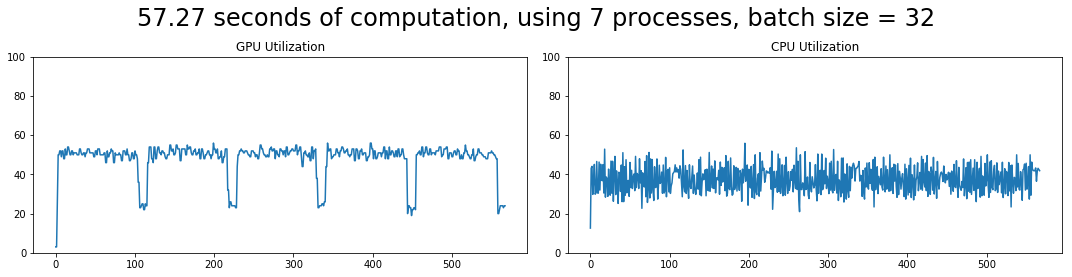

In [21]:
runs.append(run_benchmark(processes=7, batch_size=32))

In [22]:
runs[0]['duration'] / runs[1]['duration']

1.94785957414638

As we can see, we can get a **1.8x speedup by using 7 processes**. The GPU and CPU utilization is markedly higher and more consistent.

Let's see if batch size affects the outcome:

Epoch 1/5
50000/50000 [==============================] - 17s - loss: 1.0214 - acc: 0.6431 - val_loss: 0.7428 - val_acc: 0.7432
Epoch 2/5
50000/50000 [==============================] - 17s - loss: 1.0000 - acc: 0.6515 - val_loss: 0.7361 - val_acc: 0.7433
Epoch 3/5
50000/50000 [==============================] - 17s - loss: 0.9900 - acc: 0.6563 - val_loss: 0.7184 - val_acc: 0.7498
Epoch 4/5
50000/50000 [==============================] - 16s - loss: 0.9810 - acc: 0.6582 - val_loss: 0.7310 - val_acc: 0.7472
Epoch 5/5
50000/50000 [==============================] - 17s - loss: 0.9693 - acc: 0.6638 - val_loss: 0.7072 - val_acc: 0.7567


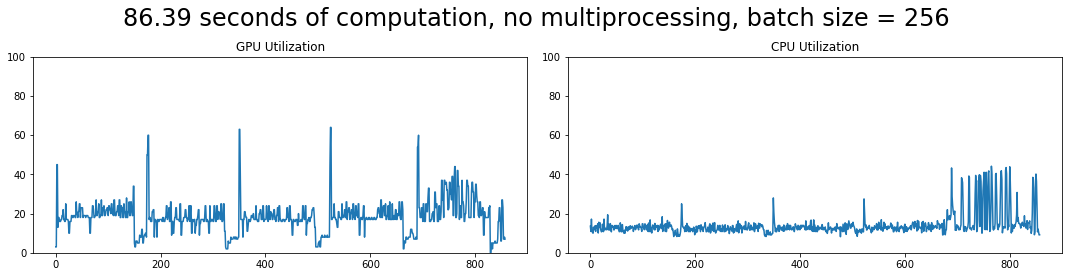

In [23]:
runs.append(run_benchmark(processes=None, batch_size=256))

Epoch 1/5
50000/50000 [==============================] - 5s - loss: 0.9553 - acc: 0.6685 - val_loss: 0.7249 - val_acc: 0.7454
Epoch 2/5
50000/50000 [==============================] - 5s - loss: 0.9547 - acc: 0.6680 - val_loss: 0.6989 - val_acc: 0.7575
Epoch 3/5
50000/50000 [==============================] - 5s - loss: 0.9463 - acc: 0.6691 - val_loss: 0.7029 - val_acc: 0.7604
Epoch 4/5
50000/50000 [==============================] - 5s - loss: 0.9532 - acc: 0.6673 - val_loss: 0.7041 - val_acc: 0.7567
Epoch 5/5
50000/50000 [==============================] - 5s - loss: 0.9465 - acc: 0.6692 - val_loss: 0.6889 - val_acc: 0.7623


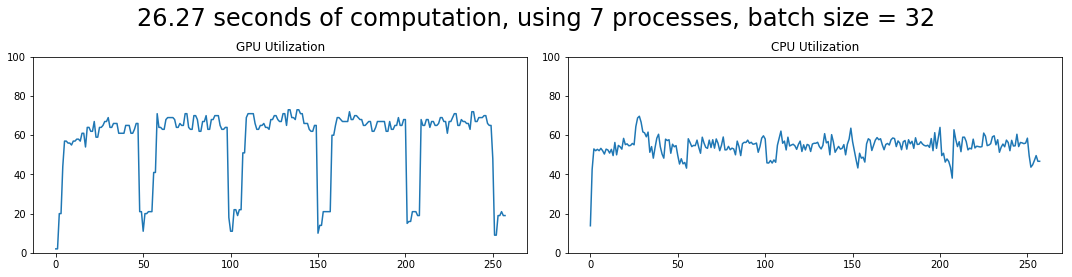

In [24]:
runs.append(run_benchmark(processes=7, batch_size=256))

In [25]:
runs[2]['duration'] / runs[3]['duration']

3.289057694541067

With a batch size of 256, we get an **even larger speedup of 3.5x**

Epoch 1/5
50000/50000 [==============================] - 18s - loss: 0.9284 - acc: 0.6746 - val_loss: 0.6775 - val_acc: 0.7654
Epoch 2/5
50000/50000 [==============================] - 15s - loss: 0.9263 - acc: 0.6784 - val_loss: 0.6660 - val_acc: 0.7673
Epoch 3/5
50000/50000 [==============================] - 15s - loss: 0.9208 - acc: 0.6787 - val_loss: 0.6776 - val_acc: 0.7630
Epoch 4/5
50000/50000 [==============================] - 16s - loss: 0.9138 - acc: 0.6794 - val_loss: 0.6754 - val_acc: 0.7647
Epoch 5/5
50000/50000 [==============================] - 15s - loss: 0.9145 - acc: 0.6800 - val_loss: 0.6630 - val_acc: 0.7685


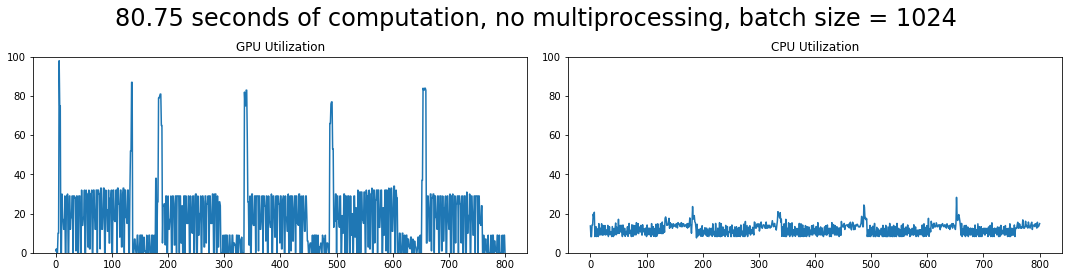

In [26]:
runs.append(run_benchmark(processes=None, batch_size=1024))

Epoch 1/5
50000/50000 [==============================] - 5s - loss: 0.9106 - acc: 0.6801 - val_loss: 0.6693 - val_acc: 0.7686
Epoch 2/5
50000/50000 [==============================] - 4s - loss: 0.9128 - acc: 0.6825 - val_loss: 0.6661 - val_acc: 0.7678
Epoch 3/5
50000/50000 [==============================] - 4s - loss: 0.9104 - acc: 0.6826 - val_loss: 0.6619 - val_acc: 0.7732
Epoch 4/5
50000/50000 [==============================] - 4s - loss: 0.9072 - acc: 0.6830 - val_loss: 0.6721 - val_acc: 0.7664
Epoch 5/5
50000/50000 [==============================] - 4s - loss: 0.9117 - acc: 0.6830 - val_loss: 0.6565 - val_acc: 0.7739


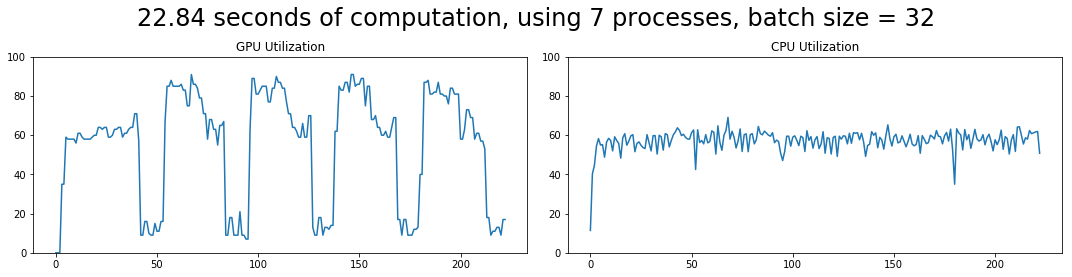

In [27]:
runs.append(run_benchmark(processes=7, batch_size=1024))

In [28]:
runs[4]['duration'] / runs[5]['duration']

3.5357571888476556

With a batch size of 1024, we get **a speedup of 3.41%**. We also notice an interesting phenomenon. Without multiprocessing, the GPU is interittently going to 0 utilization. However, with 7 processes, we can see consistent >60% GPU utilization with a long initial period of >80%. Notice that with this batch size, we are able to get to lower losses a lot quicker than with lower batch sizes. This pattern will not necessarily continue with additional epochs, but it may be promising in some cases.

Epoch 1/5
50000/50000 [==============================] - 18s - loss: 0.9048 - acc: 0.6834 - val_loss: 0.6553 - val_acc: 0.7739
Epoch 2/5
50000/50000 [==============================] - 16s - loss: 0.9043 - acc: 0.6860 - val_loss: 0.6593 - val_acc: 0.7678
Epoch 3/5
50000/50000 [==============================] - 14s - loss: 0.8925 - acc: 0.6880 - val_loss: 0.6506 - val_acc: 0.7761
Epoch 4/5
50000/50000 [==============================] - 17s - loss: 0.8962 - acc: 0.6868 - val_loss: 0.6594 - val_acc: 0.7749
Epoch 5/5
50000/50000 [==============================] - 15s - loss: 0.9010 - acc: 0.6856 - val_loss: 0.6558 - val_acc: 0.7758


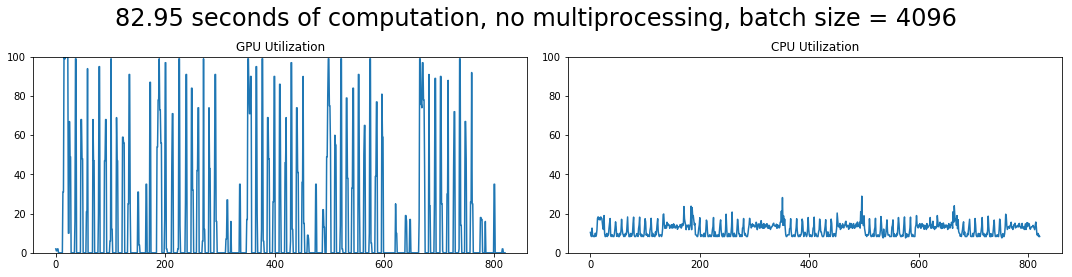

In [29]:
runs.append(run_benchmark(processes=None, batch_size=4096))

Epoch 1/5
50000/50000 [==============================] - 6s - loss: 0.8968 - acc: 0.6873 - val_loss: 0.6552 - val_acc: 0.7740
Epoch 2/5
50000/50000 [==============================] - 4s - loss: 0.8995 - acc: 0.6844 - val_loss: 0.6550 - val_acc: 0.7731
Epoch 3/5
50000/50000 [==============================] - 4s - loss: 0.8958 - acc: 0.6853 - val_loss: 0.6443 - val_acc: 0.7769
Epoch 4/5
50000/50000 [==============================] - 4s - loss: 0.8976 - acc: 0.6858 - val_loss: 0.6572 - val_acc: 0.7741
Epoch 5/5
50000/50000 [==============================] - 4s - loss: 0.8940 - acc: 0.6906 - val_loss: 0.6536 - val_acc: 0.7757


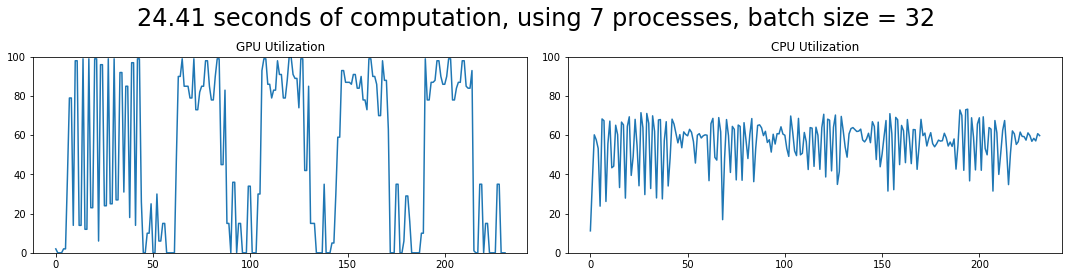

In [30]:
runs.append(run_benchmark(processes=7, batch_size=4096))

In [31]:
runs[6]['duration'] / runs[7]['duration']

3.3979756052834253

A larger batch size of 4096 may or may not be a good choice in all cases, but when it comes to measuring system performance, we can see that the GPU usage is not consistent in the single process case. On the other hand, we are getting between 80-100% GPU utilization with 7 processes. **Doesn't it feel good to get the most out of your machine? :) ** 

## Dog vs. Cat Benchmark

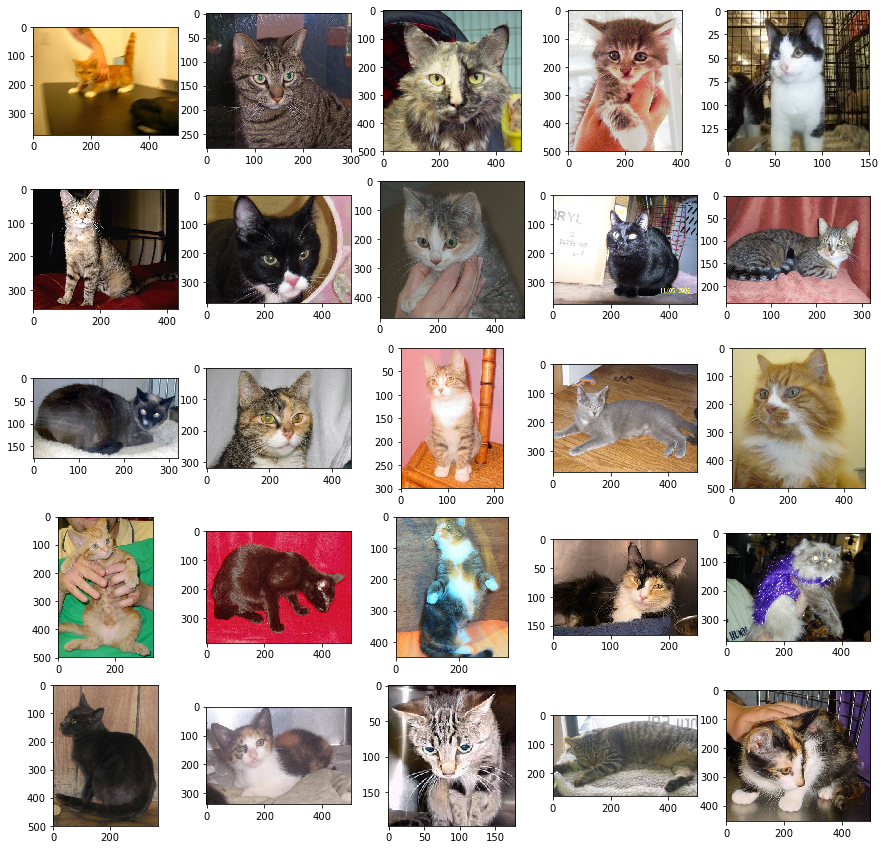

In [32]:
import os

paths = sorted(os.listdir('./data/train/cat'))

fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ix = i*5 + j
        img = plt.imread('./data/train/cat/' + paths[ix])
        ax[i][j].imshow(img)


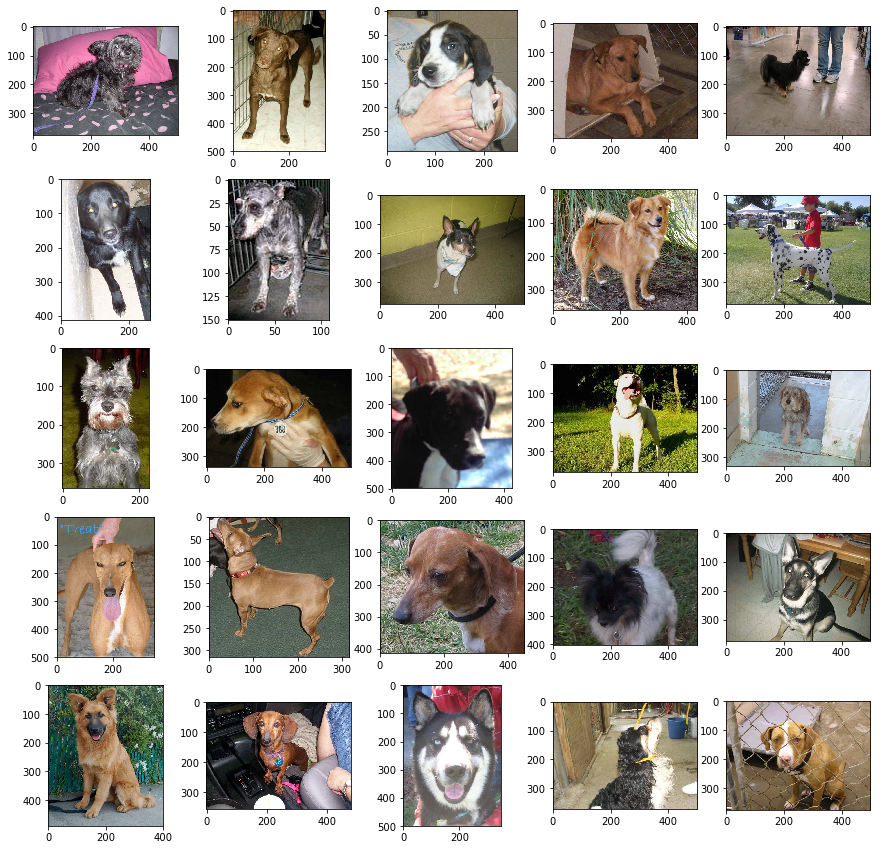

In [33]:
paths = sorted(os.listdir('./data/train/dog'))

fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ix = i*5 + j
        img = plt.imread('./data/train/dog/' + paths[ix])
        ax[i][j].imshow(img)


Found 22778 images belonging to 2 classes.
Found 2222 images belonging to 2 classes.


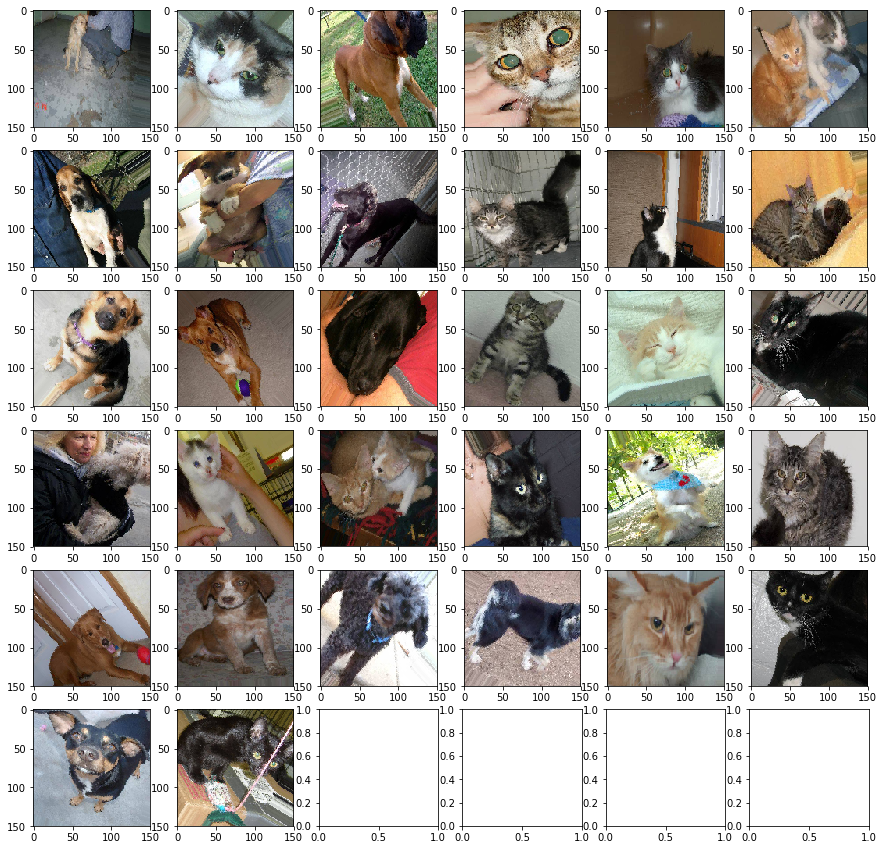

In [34]:
gen = T.ImageDataGenerator(
     featurewise_center=False,
     samplewise_center=False,
     featurewise_std_normalization=False,
     samplewise_std_normalization=False,
     zca_whitening=False,
     rotation_range=45,
     width_shift_range=.1,
     height_shift_range=.1,
     shear_range=0.,
     zoom_range=[.8, 1],
     channel_shift_range=0,
     fill_mode='nearest',
     cval=0.,
     horizontal_flip=True,
     vertical_flip=False,
     rescale=1/255.,
#      preprocessing_function=preprocess_img,
     #dim_ordering='default',
#      pool=None
)
test_gen = T.ImageDataGenerator(
    preprocessing_function=preprocess_img,
#     pool=None
)


train_generator = gen.flow_from_directory(
    'data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

test_generator = gen.flow_from_directory(
    'data/validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

fig, ax = plt.subplots(6, 6, figsize=(15, 15))
for (imgs, labels) in train_generator:
    for i in range(6):
        for j in range(6):
            if i*6 + j < 32:
                ax[i][j].imshow(imgs[i*6 + j])
    break


In [47]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(299, 299, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [48]:
def setup_cat_dog_generator(processes=None, batch_size=32):
    global pool
    try:
        pool.terminate()
    except:
        pass

    if processes: 
        pool = multiprocessing.Pool(processes=processes, initializer=init_worker)
    else:
        pool = None

    gen = T.ImageDataGenerator(
         featurewise_center=False,
         samplewise_center=False,
         featurewise_std_normalization=False,
         samplewise_std_normalization=False,
         zca_whitening=False,
         rotation_range=45,
         width_shift_range=.1,
         height_shift_range=.1,
         shear_range=0.,
         zoom_range=[.8, 1],
         channel_shift_range=20,
         fill_mode='nearest',
         cval=0.,
         horizontal_flip=True,
         vertical_flip=False,
         rescale=None,
         preprocessing_function=preprocess_img,
         dim_ordering='default',
         pool=pool
    )
    test_gen = T.ImageDataGenerator(
        preprocessing_function=preprocess_img,
        pool=pool
    )
    
    gen.fit(X_train)
    test_gen.fit(X_train)
    
    X_train_aug = gen.flow_from_directory(
        'data/train',
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='binary')

    X_test_aug = gen.flow_from_directory(
        'data/validation',
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='binary')
    
    return X_train_aug, X_test_aug

In [49]:
def run_cat_dog_benchmark(processes=None, batch_size=32, vert=False):
    X_train_aug, X_test_aug = setup_cat_dog_generator(processes=processes, batch_size=batch_size)
    sys_mon = SM.SysMonitor()
    sys_mon.start()
    
    try:        
        model.fit_generator(
                X_train_aug,
                samples_per_epoch=22778,
                nb_epoch=2,
                validation_data=X_test_aug,
                nb_val_samples=2222)
    except KeyboardInterrupt:
        print '\n\nTraining Interrupted\n'
        return None

    sys_mon.stop()
    
    title = None
    if not processes:
        title = '{0:.2f} seconds of computation, no multiprocessing, batch size = {1}'.format(sys_mon.duration, batch_size)
    else:
        title = '{0:.2f} seconds of computation, using {1} processes, batch size = {2}'.format(sys_mon.duration, processes, 32)
    
    sys_mon.plot(title, vert)
    
    if not processes:
        processes = 0
        
    return {
        'processes': processes,
        'batch_size': batch_size,
        'duration': sys_mon.duration,
        'title': title
    }

Found 22778 images belonging to 2 classes.
Found 2222 images belonging to 2 classes.
Epoch 1/2
22778/22778 [==============================] - 319s - loss: 0.5527 - acc: 0.7261 - val_loss: 0.5172 - val_acc: 0.7444
Epoch 2/2
22778/22778 [==============================] - 317s - loss: 0.5356 - acc: 0.7392 - val_loss: 0.5681 - val_acc: 0.7138


{'batch_size': 32,
 'duration': 637.0153040885925,
 'processes': 0,
 'title': '637.02 seconds of computation, no multiprocessing, batch size = 32'}

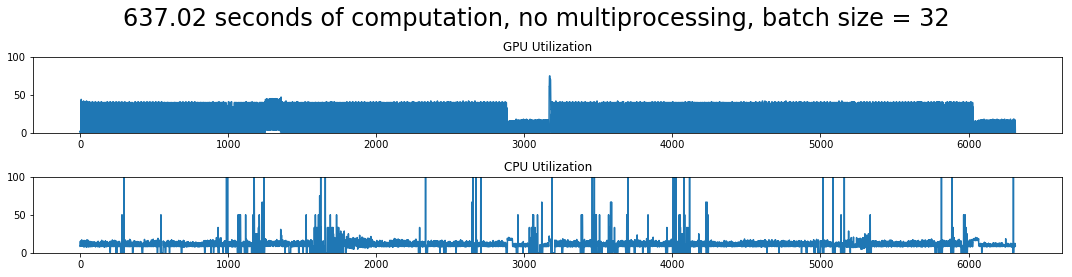

In [51]:
run_cat_dog_benchmark(processes=None, batch_size=32, vert=True)

Found 22778 images belonging to 2 classes.
Found 2222 images belonging to 2 classes.
Epoch 1/2
22778/22778 [==============================] - 91s - loss: 0.6604 - acc: 0.6285 - val_loss: 0.5487 - val_acc: 0.7286
Epoch 2/2
22778/22778 [==============================] - 90s - loss: 0.5785 - acc: 0.7106 - val_loss: 0.5558 - val_acc: 0.7187


{'batch_size': 32,
 'duration': 182.34784579277039,
 'processes': 7,
 'title': '182.35 seconds of computation, using 7 processes, batch size = 32'}

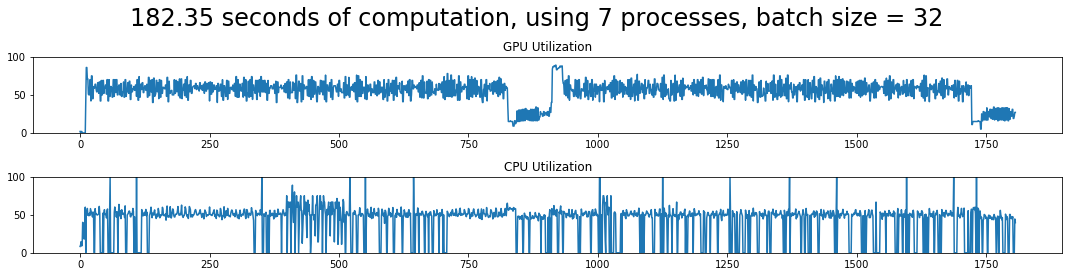

In [50]:
run_cat_dog_benchmark(processes=7, batch_size=32, vert=True)

In [92]:
666.53/182.0656

3.6610458090739315